Days until 100k: 27.422547913757626
2020-11-03 00:00:00
2020-07-27 00:00:00
7/27/20
308
275875
276920
336510
Estimated deaths per day: 1045.4389610389612


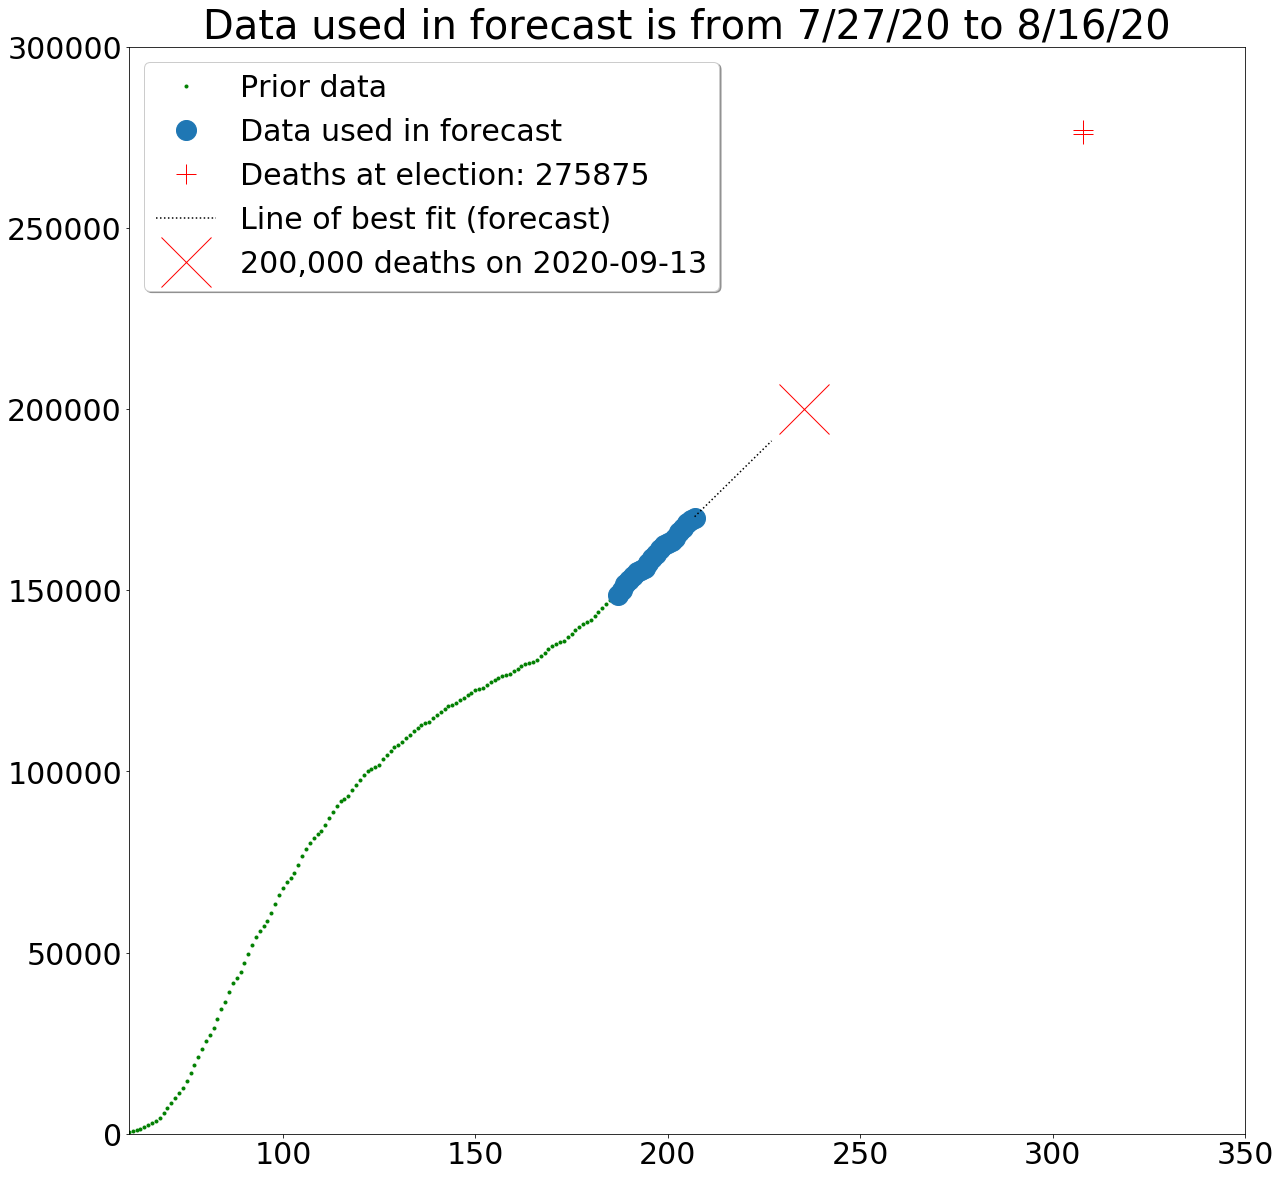

<Figure size 432x288 with 0 Axes>

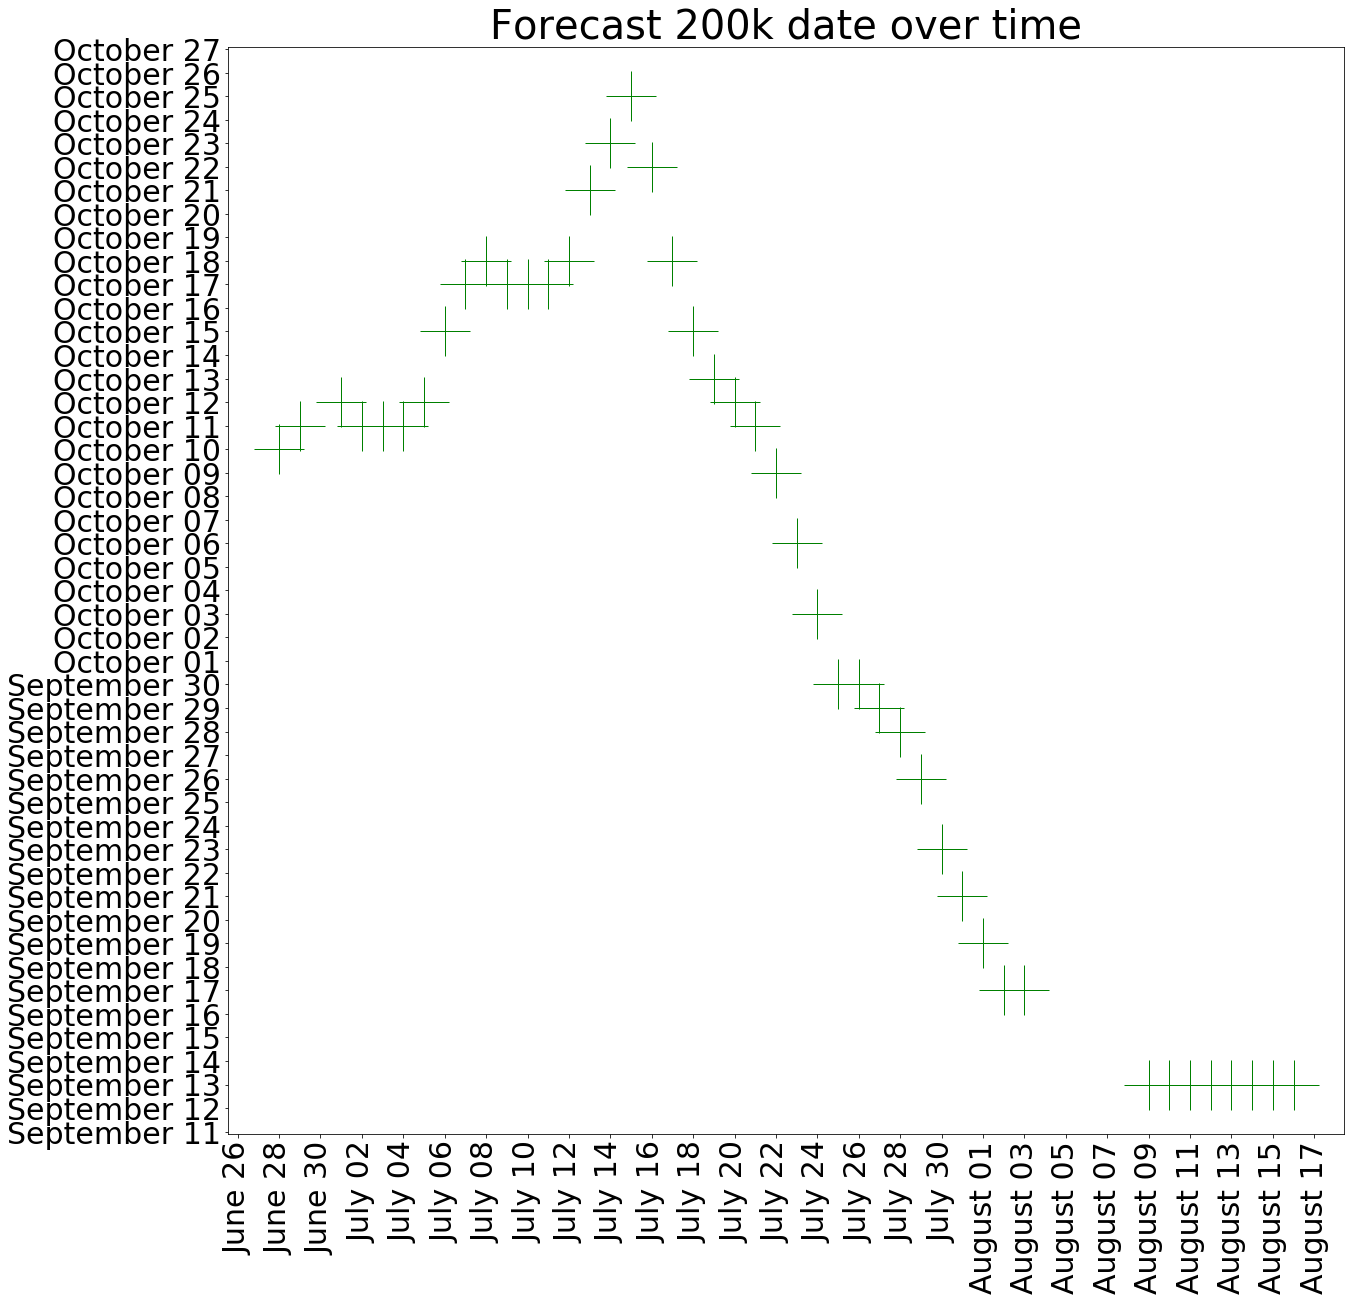

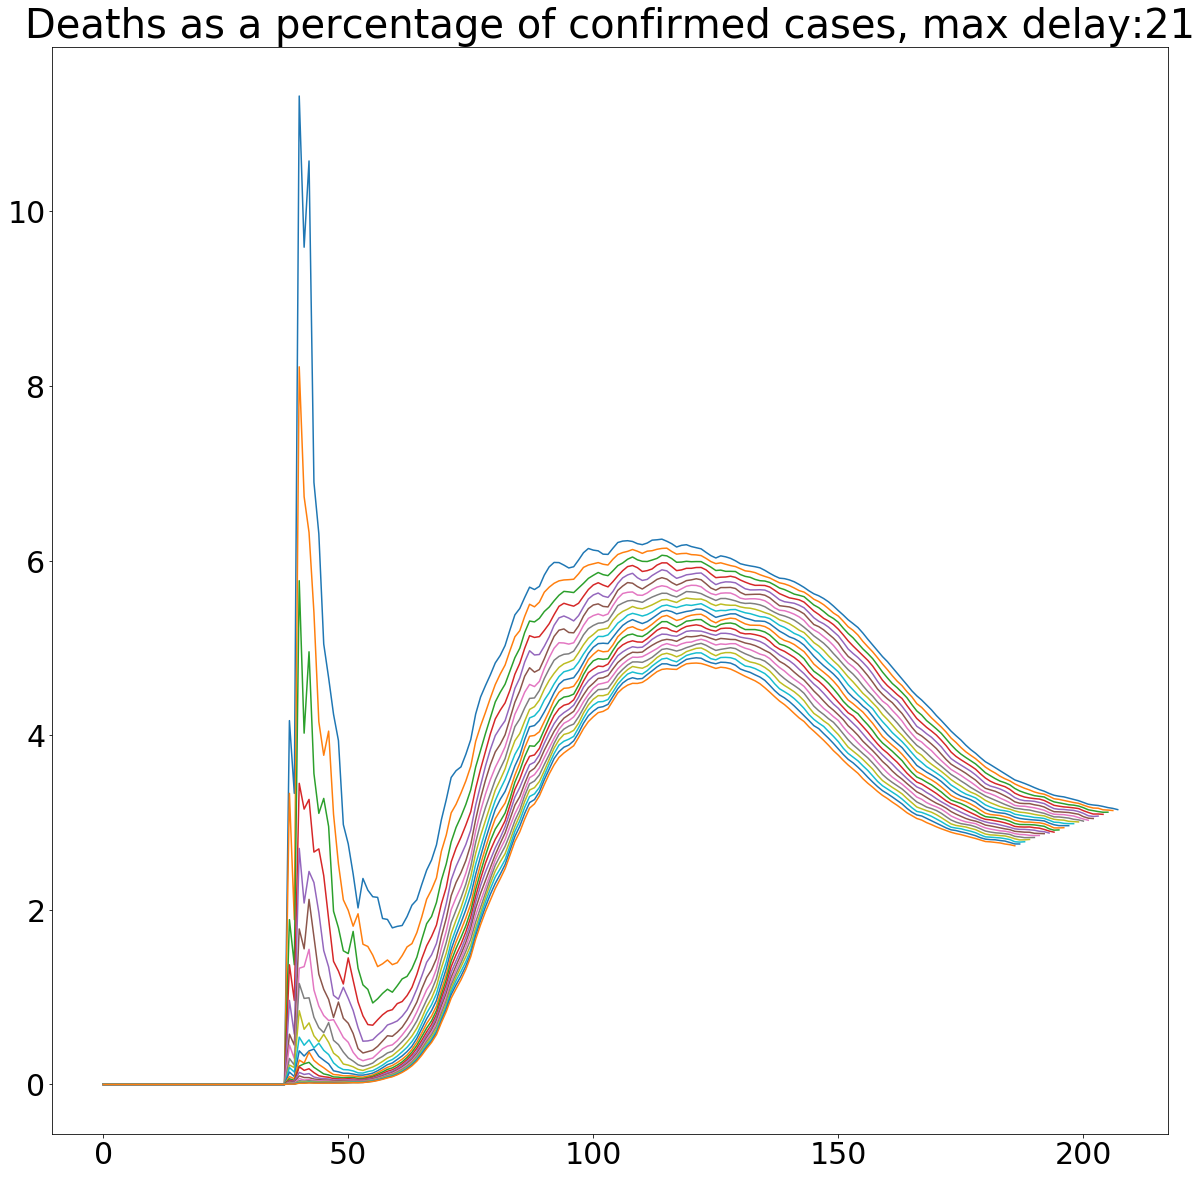

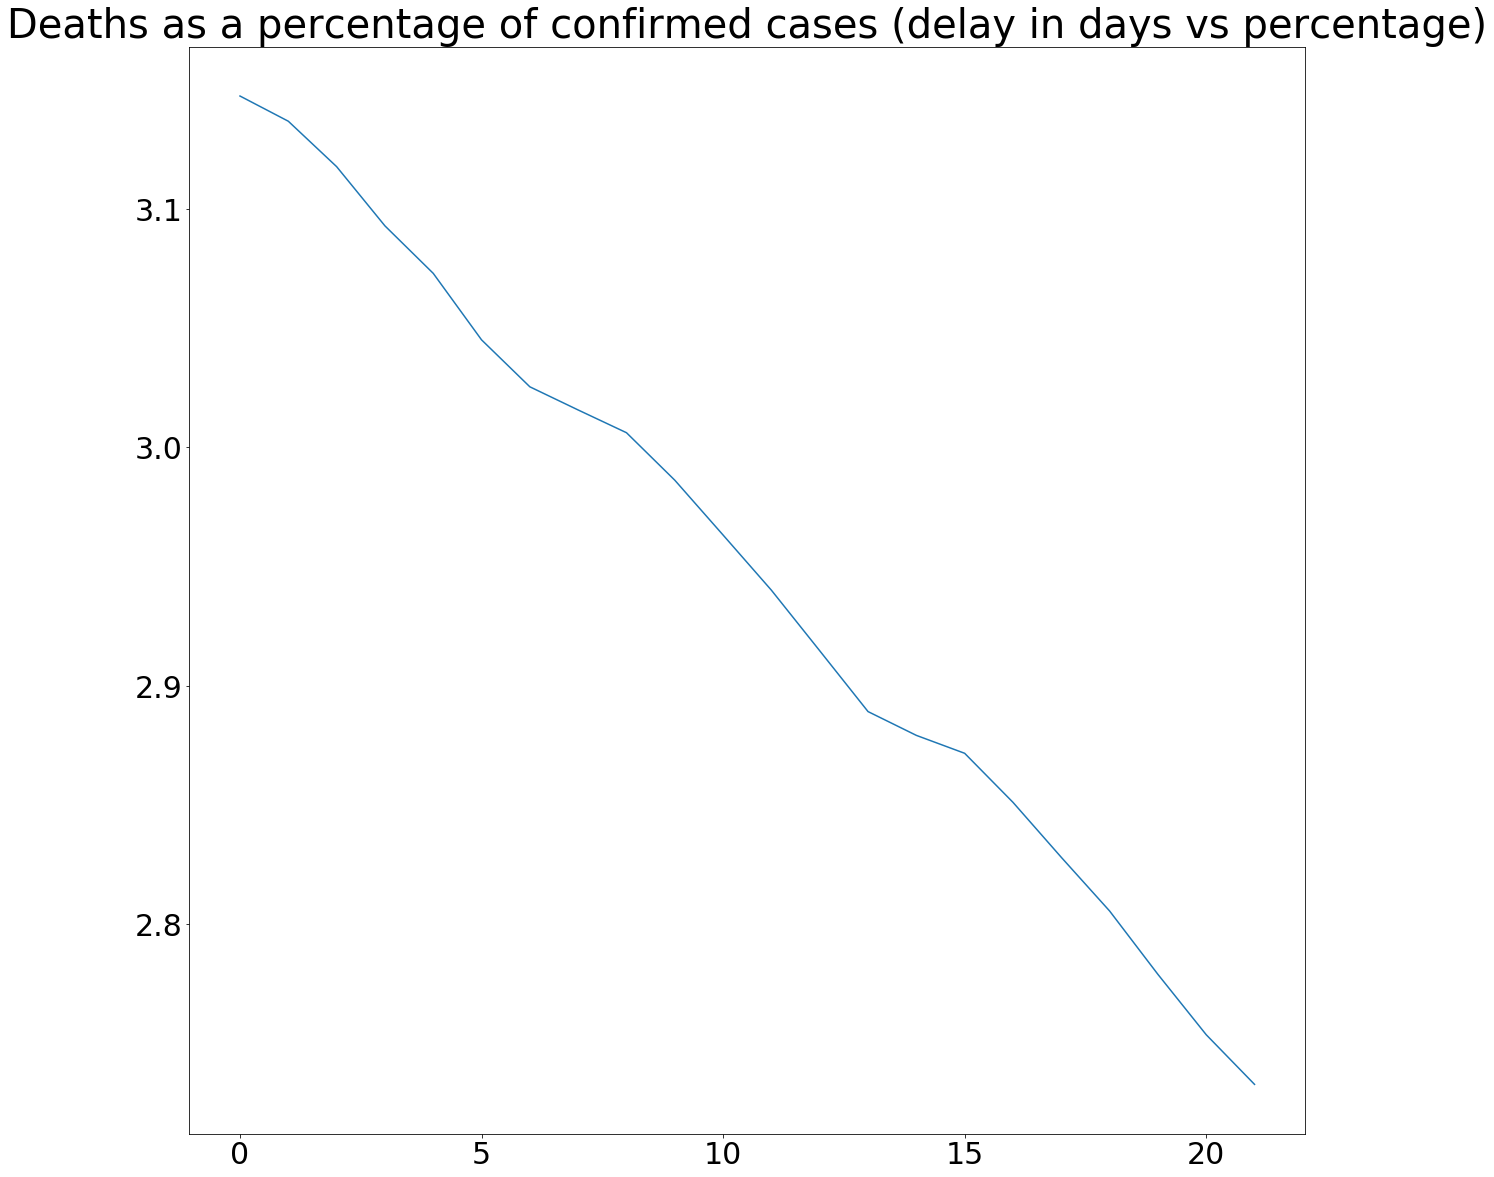

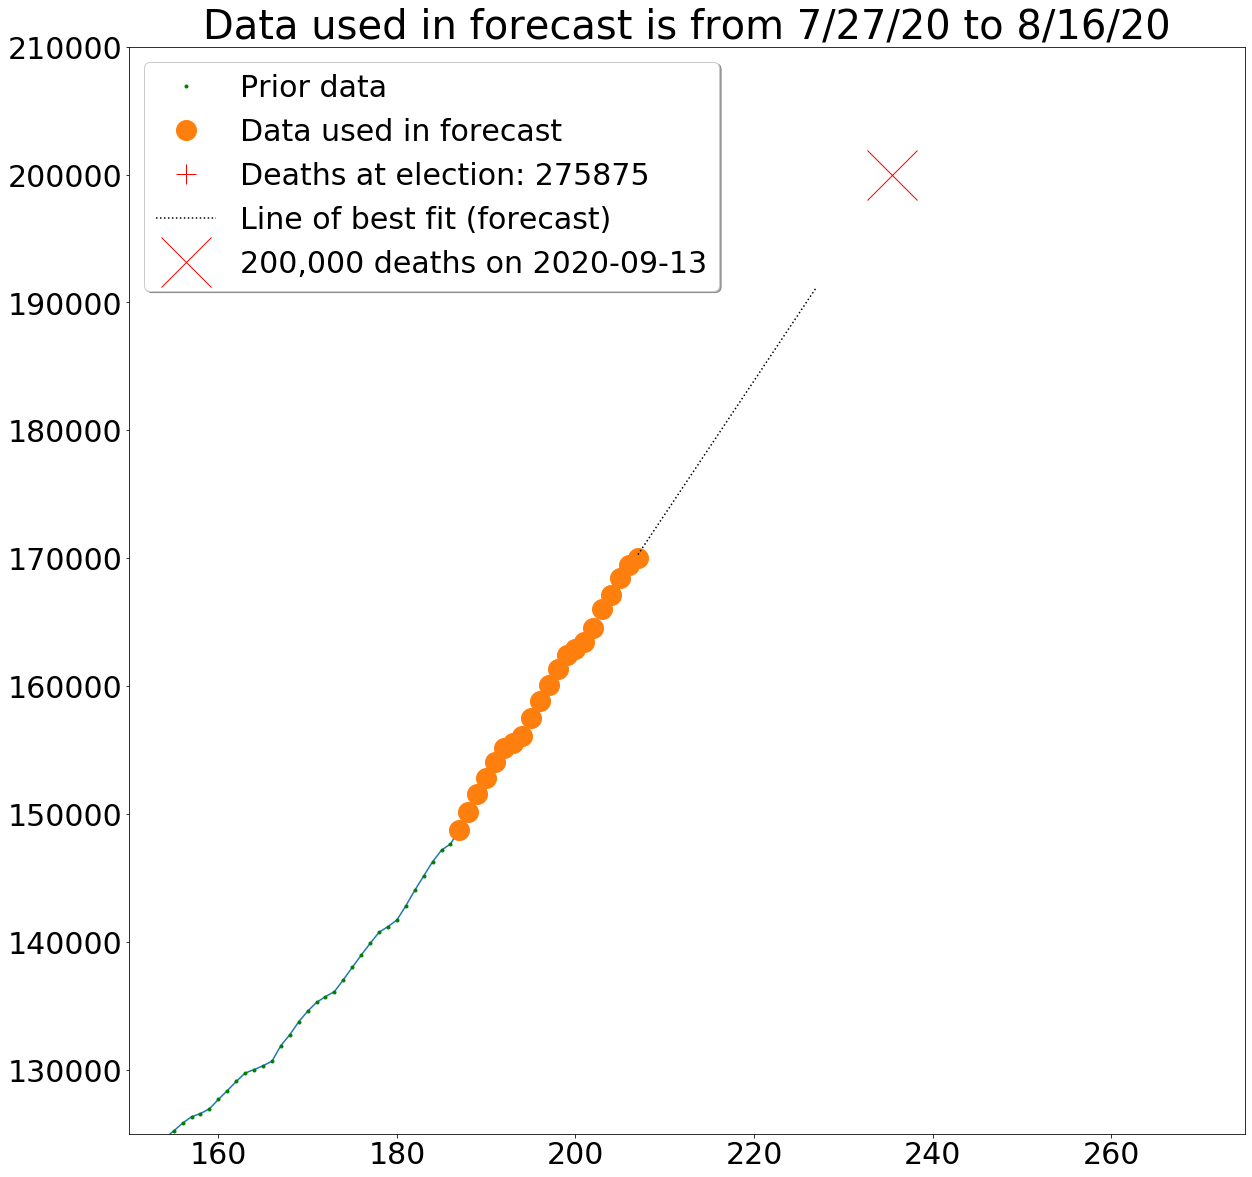

In [3]:
from numpy import log10, asarray, polyfit, ceil, arange
import csv
import matplotlib.pyplot as plt
from numpy import log10, asarray, polyfit, ceil, arange
import csv
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import json
import os.path
from os import path
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

def read_covid_data(data_type):
    if (data_type in ['confirmed', 'deaths', 'recovered']):
        COVID_directory = "/Users/kootsoop/git/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"
        first_row = None
        with open(COVID_directory + 'time_series_covid19_' + data_type + '_global.csv') as csvfile:
            confirmed = csv.reader(csvfile)
            for row in confirmed:
                if (first_row == None):
                    first_row = row
                if (row[1] == 'US'):
                    us_data = row
                    break
    else:
        raise Exception('Invalid data_type', data_type)
    return(first_row, us_data)

FORECAST_FILE = 'forecasts200k.txt'
if (path.exists(FORECAST_FILE)):
    forecast_file = open(FORECAST_FILE, 'r')
    forecasts200k = json.load(forecast_file)
    forecast_file.close()
else:
    forecasts200k = {}

(first_row, confirmed) = read_covid_data('confirmed')
(first_row2, recovered) = read_covid_data('recovered')
(first_row3, deaths) = read_covid_data('deaths')

# print(first_row[4:(len(first_row)-1)])
# print(deaths)
# print(str(len(first_row)) + ' ' \
#       +  str(len(confirmed))+ ' ' +  str(len(first_row2))+ ' ' +  str(len(recovered))+ ' ' \
#       +  str(len(first_row3))+ ' ' +  str(len(deaths)))

death_data = [(float(data)) for data in deaths[4:(len(first_row))]]
recovered_data = [(float(data)) for data in recovered[4:(len(first_row))]]
confirmed_data = [(float(data)) for data in confirmed[4:(len(first_row))]]

first_row_shifted = [ data for data in first_row[4:(len(first_row))]]
x_axis = arange(len(death_data))

NumberInEstimateWindow = 20

# Started at 70 @ 2020/5/10
# 133 2020/06/24
# 137 2020/06/28
start_fit = len(death_data) - (NumberInEstimateWindow + 1)
# Started 20 more than start_fit
end_fit = start_fit + NumberInEstimateWindow
y_fit_data = death_data[start_fit:end_fit+1]
x_fit_data = arange(start_fit,end_fit+1)

y_pre = death_data[1:start_fit]
x_pre = arange(1,start_fit)


y_new_data = death_data[end_fit+1:len(death_data)]
x_new_data = arange(end_fit+1, len(death_data))

x_forecast = arange(end_fit, len(death_data) + 20)

[m, b] = polyfit(x_fit_data, y_fit_data, 1)

day_for_100k = (200000-b)/m


days_until = day_for_100k - len(first_row_shifted) 

print('Days until 100k: ' + str(day_for_100k - len(first_row_shifted) ))

plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)


date_for_200k = (datetime.now() + timedelta(days=days_until)).date()

if (not first_row_shifted[end_fit] in forecasts200k):
    print("Updating file.")
    forecasts200k.update({ first_row_shifted[end_fit] : str(date_for_200k) })
    forecast_file = open(FORECAST_FILE, 'w+')
    json.dump(forecasts200k, forecast_file)
    forecast_file.close()


dates = []
forecasts = []
for date in forecasts200k:
    # print(str(date) + ' ' + str(forecasts200k[date]))
    forecasts.append(datetime.strptime(forecasts200k[date], '%Y-%m-%d'))
    dates.append(datetime.strptime(date, '%m/%d/%y'))
    
election_date = datetime.strptime('2020-11-03', '%Y-%m-%d')
election_day_of_year = (election_date - datetime(election_date.year, 1, 1)).days + 1

start_data_date = datetime.strptime(first_row_shifted[start_fit], '%m/%d/%y')
deaths_at_election = int(m*(election_day_of_year)+b)
deaths_at_election_end = int(m*(election_day_of_year+1)+b)

end_of_year_date = datetime.strptime('2020-12-31', '%Y-%m-%d')
end_of_year_day = (end_of_year_date - datetime(end_of_year_date.year, 1, 1)).days + 1
deaths_at_end_of_year = int(m*(end_of_year_day)+b)

print(election_date)
print(start_data_date)
print(first_row_shifted[start_fit])
print(election_day_of_year)
print(deaths_at_election)
print(deaths_at_election_end)
print(deaths_at_end_of_year)
print('Estimated deaths per day: ' + str(m))

plt.figure(1)
plt.plot(x_pre, y_pre, 'g.', label='Prior data')
plt.plot(x_fit_data, y_fit_data,'o', markersize=20, label='Data used in forecast')
plt.plot([election_day_of_year, election_day_of_year], [deaths_at_election, deaths_at_election_end],'r+',markersize=20,  label='Deaths at election: ' + str(deaths_at_election))
plt.plot(x_forecast, m*x_forecast + b,'k:',markersize=14,  label='Line of best fit (forecast)')
plt.plot(day_for_100k, 200000, 'rx', markersize=50, label='200,000 deaths on ' + str(date_for_200k))
plt.ylim(0,300000)
plt.xlim(60,350)
plt.title('Data used in forecast is from ' + first_row_shifted[start_fit] + ' to ' + first_row_shifted[end_fit], fontsize=40)
ax.legend(loc='upper left', shadow=True, fontsize=30)

plt.savefig('/Users/kootsoop/Pictures/COVID-19-FORECAST-' + first_row_shifted[end_fit].replace('/','-') + '.png')

death_percent = [i / j * 100.0 for i, j in zip(death_data, confirmed_data)] 


plt.figure(2)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.yaxis.set_major_formatter(mdates.DateFormatter("%B %d"))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%B %d"))
plt.xticks(rotation=90)
ax.xaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.plot(dates, forecasts,'g+', markersize=50)
plt.title('Forecast 200k date over time', fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-FORECAST-HISTORY-' + first_row_shifted[end_fit].replace('/','-') + '.png')
# Doesn't seem to do the right thing: ax.set_xticklabels(dates)

plt.figure(3)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)

death_by_delay = {}

for delay in arange(22):
    death_percent_with_delay = [i / j * 100.0 for i, j in zip(death_data[0:len(death_data)-delay], confirmed_data[delay:len(confirmed_data)])] 
    plt.plot(x_axis[0:len(death_data)-delay], death_percent_with_delay)
    death_by_delay[delay] = death_percent_with_delay[len(death_percent_with_delay)-1]
plt.title('Deaths as a percentage of confirmed cases, max delay:' + str(delay), fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-DEATH-RATE-DELAY.png')

plt.figure(4)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)
death_list = sorted(death_by_delay.items())
x,y = zip(*death_list)
plt.plot(x, y)
plt.title('Deaths as a percentage of confirmed cases (delay in days vs percentage)', fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-DEATH-RATE-ESTIMATE.png')

plt.figure(5)
plt.figure(figsize=(20,20))
ax = plt.gca()
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=8)
plt.plot(x_axis , death_data)
# plt.plot(x_axis, confirmed_data, 'r')
plt.title('Deaths and confirmed numbers.', fontsize=40)
plt.savefig('/Users/kootsoop/Pictures/COVID-19-DEATH-RATE-DEATHS-AND-CONFIRMED.png')

plt.figure(6)
plt.plot(x_pre, y_pre, 'g.', label='Prior data')
plt.plot(x_fit_data, y_fit_data,'o', markersize=20, label='Data used in forecast')
plt.plot([election_day_of_year, election_day_of_year], [deaths_at_election, deaths_at_election_end],'r+',markersize=20,  label='Deaths at election: ' + str(deaths_at_election))
plt.plot(x_forecast, m*x_forecast + b,'k:',markersize=14,  label='Line of best fit (forecast)')
plt.plot(day_for_100k, 200000, 'rx', markersize=50, label='200,000 deaths on ' + str(date_for_200k))
plt.ylim(125000,210000)
plt.xlim(150,275)
plt.title('Data used in forecast is from ' + first_row_shifted[start_fit] + ' to ' + first_row_shifted[end_fit], fontsize=40)
ax.legend(loc='upper left', shadow=True, fontsize=30)


